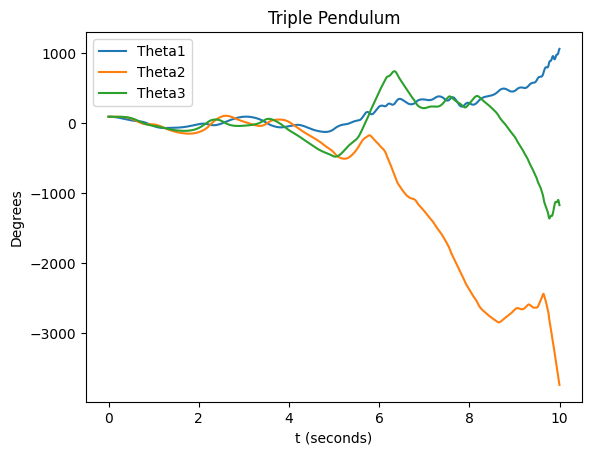

Saved: triple_pendulum_data_90_90_90.npy


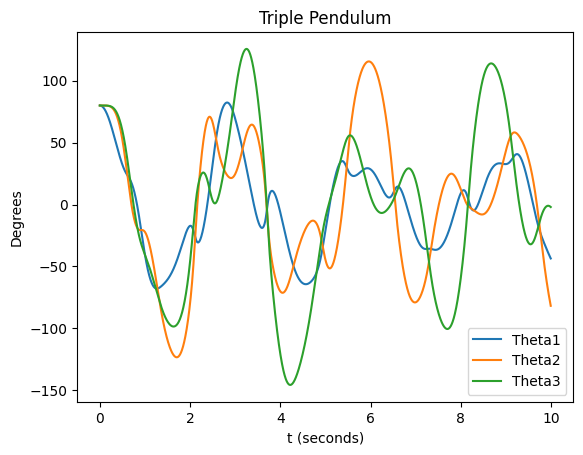

Saved: triple_pendulum_data_80_80_80.npy


In [ ]:

from __future__ import division, print_function
from math import sin, pi
import numpy as np
from pylab import plot, xlabel, ylabel, show
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi, radians
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
from numpy import array

# Constants
g = 9.81  # Acceleration due to gravity
L1, L2, L3 = 1.0, 1.0, 1.0  # Lengths of pendulums
m1, m2, m3 = 1.0, 1.0, 1.0  # Masses of pendulums

def f(r, t):
    theta1, omega1, theta2, omega2, theta3, omega3 = r

    ftheta1 = omega1
    ftheta2 = omega2
    ftheta3 = omega3

    delta12 = theta1 - theta2
    delta13 = theta1 - theta3
    delta23 = theta2 - theta3

    denom1 = L1 * (2 * m1 + m2 + m3 - m2 * cos(2 * delta12) - m3 * cos(2 * delta13))
    denom2 = L2 * (2 * m1 + m2 + m3 - m2 * cos(2 * delta12) - m3 * cos(2 * delta23))
    denom3 = L3 * (2 * m1 + m2 + m3 - m3 * cos(2 * delta13))

    fomega1 = (-g * (2 * m1 + m2 + m3) * sin(theta1)
               - m2 * g * sin(theta1 - 2 * theta2)
               - m3 * g * sin(theta1 - 2 * theta3)
               - 2 * sin(delta12) * m2 * (omega2**2 * L2 + omega1**2 * L1 * cos(delta12))
               - 2 * sin(delta13) * m3 * (omega3**2 * L3 + omega1**2 * L1 * cos(delta13))) / denom1

    fomega2 = (2 * sin(delta12) * (omega1**2 * L1 * (m1 + m2 + m3)
                                   + g * (m1 + m2 + m3) * cos(theta1)
                                   + omega2**2 * L2 * m2 * cos(delta12)
                                   + omega3**2 * L3 * m3 * cos(delta13))) / denom2

    fomega3 = (2 * sin(delta13) * (omega1**2 * L1 * (m1 + m2 + m3)
                                   + g * (m1 + m2 + m3) * cos(theta1)
                                   + omega2**2 * L2 * m2 * cos(delta23)
                                   + omega3**2 * L3 * m3 * cos(delta13))) / denom3

    return array([ftheta1, fomega1, ftheta2, fomega2, ftheta3, fomega3], float)

# Time parameters
a, b = 0.0, 10.0
N = 2000
h = (b - a) / N
tpoints = np.arange(a, b, h)

# Initial conditions (angles in degrees, converted to radians)
angles = [[90, 90, 90], [80, 80, 80]]

for x in angles:
    theta1_points = np.zeros_like(tpoints)
    theta2_points = np.zeros_like(tpoints)
    theta3_points = np.zeros_like(tpoints)

    # Initial angles (convert to radians)
    r = np.array([x[0] * pi / 180, 0, x[1] * pi / 180, 0, x[2] * pi / 180, 0], float)

    for i, t in enumerate(tpoints):
        theta1_points[i] = r[0] * 180 / pi
        theta2_points[i] = r[2] * 180 / pi
        theta3_points[i] = r[4] * 180 / pi

        # Runge-Kutta method
        k1 = h * f(r, t)
        k2 = h * f(r + 0.5 * k1, t + 0.5 * h)
        k3 = h * f(r + 0.5 * k2, t + 0.5 * h)
        k4 = h * f(r + k3, t + h)
        r += (k1 + 2 * k2 + 2 * k3 + k4) / 6

    plt.plot(tpoints, theta1_points, label='Theta1')
    plt.plot(tpoints, theta2_points, label='Theta2')
    plt.plot(tpoints, theta3_points, label='Theta3')
    plt.title("Triple Pendulum")
    plt.xlabel("t (seconds)")
    plt.ylabel("Degrees")
    plt.legend()
    plt.show()


    data = np.stack((theta1_points, theta2_points, theta3_points), axis=1)
    np.save(f'triple_pendulum_data_{str(x[0])}_{str(x[1])}_{str(x[2])}.npy', data)
    print(f'Saved: triple_pendulum_data_{str(x[0])}_{str(x[1])}_{str(x[2])}.npy')


In [ ]:
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define the dataset class
class QuadraticDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)  # Shape (N, 2)
        self.y = torch.tensor(y, dtype=torch.float32)  # Shape (N, 2)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx].unsqueeze(0), self.y[idx]

data = {}

for i in angles:
  loaded_data = np.load(f'triple_pendulum_data_{str(i[0])}_{str(i[1])}_{str(i[2])}.npy')
  scaler = MinMaxScaler()
  data_ = scaler.fit_transform(loaded_data)
  data[f'{str(i[0])}_{str(i[1])}_{str(i[2])}'] = data_

def create_io_triple(data):
    x, x_1, x_2, x_3, y_1, y_2, y_3 = [], [], [], [], [], [], []

    for starting in data:
        starting_theta_1_degrees = int(starting.split("_")[0])
        starting_theta_2_degrees = int(starting.split("_")[1])
        starting_theta_3_degrees = int(starting.split("_")[2])

        starting_theta_1 = starting_theta_1_degrees * pi /180
        starting_theta_2 = starting_theta_2_degrees * pi /180
        starting_theta_3 = starting_theta_3_degrees * pi /180

        angle_data = data[starting]
        for i in range(len(angle_data)):
            x.append(tpoints[i])
            x_1.append(starting_theta_1)
            x_2.append(starting_theta_2)
            x_3.append(starting_theta_3)
            y_1.append(angle_data[i][0])
            y_2.append(angle_data[i][1])
            y_3.append(angle_data[i][2])
    return x, x_1, x_2, x_3, y_1, y_2, y_3

x, x_1, x_2, x_3, y_1, y_2, y_3 = create_io_triple(data)

x_combined = np.vstack([x_1, x_2, x_3, x]).T
scaler_x = MinMaxScaler()
x_scaled = scaler_x.fit_transform(x_combined)

y_combined = np.vstack([y_1, y_2, y_3]).T
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_combined)

# Create dataset and dataloaders
dataset = QuadraticDataset(torch.tensor(x_scaled, dtype=torch.float32), torch.tensor(y_scaled, dtype=torch.float32))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

<ipython-input-17-836ecf262e89>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32)  # Shape (N, 2)
<ipython-input-17-836ecf262e89>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)  # Shape (N, 2)


Epoch 1 Train Loss: 7.153702, Val Loss: 4.327782
Epoch 2 Train Loss: 2.719883, Val Loss: 1.544142
Epoch 3 Train Loss: 0.930765, Val Loss: 0.510786
Epoch 4 Train Loss: 0.315153, Val Loss: 0.196797
Epoch 5 Train Loss: 0.144674, Val Loss: 0.120510
Epoch 6 Train Loss: 0.103644, Val Loss: 0.100166
Epoch 7 Train Loss: 0.089967, Val Loss: 0.089758
Epoch 8 Train Loss: 0.081208, Val Loss: 0.081409
Epoch 9 Train Loss: 0.073979, Val Loss: 0.074299
Epoch 10 Train Loss: 0.067937, Val Loss: 0.068562
Epoch 11 Train Loss: 0.063111, Val Loss: 0.063933
Epoch 12 Train Loss: 0.059362, Val Loss: 0.060200
Epoch 13 Train Loss: 0.056483, Val Loss: 0.057381
Epoch 14 Train Loss: 0.054411, Val Loss: 0.055327
Epoch 15 Train Loss: 0.052857, Val Loss: 0.053771
Epoch 16 Train Loss: 0.051757, Val Loss: 0.052709
Epoch 17 Train Loss: 0.050930, Val Loss: 0.051808
Epoch 18 Train Loss: 0.050235, Val Loss: 0.051032
Epoch 19 Train Loss: 0.049680, Val Loss: 0.050262
Epoch 20 Train Loss: 0.049215, Val Loss: 0.049753
Epoch 21 

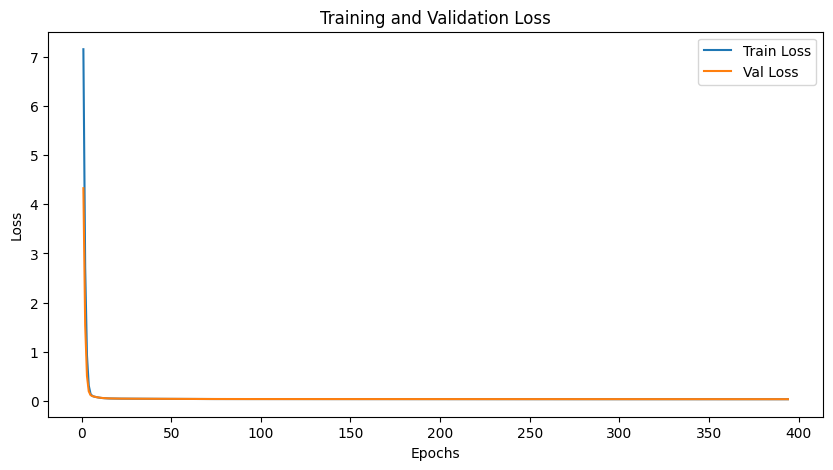

Test RMSE: 0.19313903152942657
Test R^2 Score: 0.38487459898532156


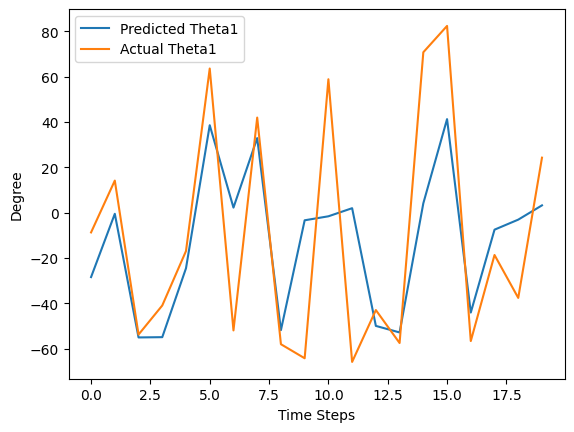

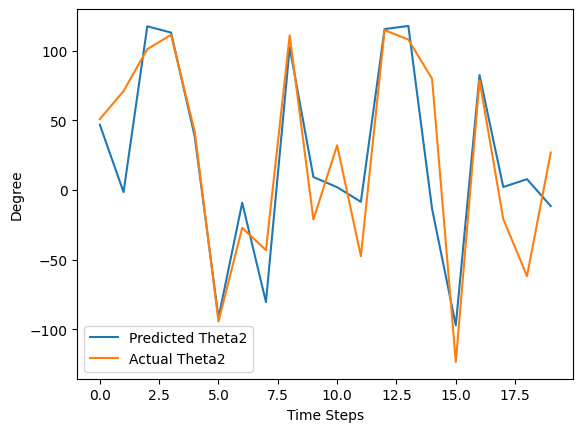

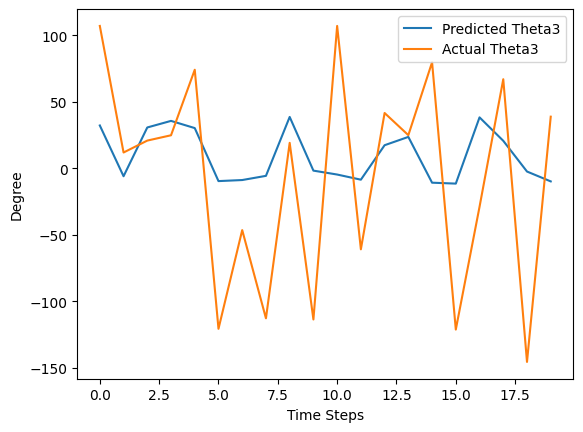

In [ ]:
class AutoregressiveModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AutoregressiveModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size
        h0 = torch.zeros(1, batch_size, self.hidden_dim).to(x.device)  # Initialize h0 as a 3-D tensor
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Pass the last time step output to the fully connected layer
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, criterion, optimizer setup
input_dim = 4
hidden_dim = 50
output_dim = 3
model = AutoregressiveModel(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Weights and Biases Initialization
for name, param in model.named_parameters():
    if 'weight' in name:
        nn.init.xavier_normal_(param)
    elif 'bias' in name:
        nn.init.uniform_(param, -5, 5)

# Early stopping variables
num_epochs = 500
patience = 20
best_loss = float('inf')
patience_counter = 0

# Store losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item() * data.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data_val, targets_val in test_loader:
            data_val, targets_val = data_val.to(device), targets_val.to(device)
            outputs_val = model(data_val)
            loss_val = criterion(outputs_val, targets_val)
            val_loss += loss_val.item() * data_val.size(0)

    avg_val_loss = val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1} Train Loss: {avg_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping logic
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping after epoch {epoch+1}')
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred.append(outputs.cpu().numpy())
        y_true.append(targets.cpu().numpy())

y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Calculate performance
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print(f'Test RMSE: {rmse}')
print(f'Test R^2 Score: {r2}')

# Inverse transform the predictions and true values
y_pred = scaler.inverse_transform(y_pred)
y_true = scaler.inverse_transform(y_true)

# Plot actual vs predicted angles
plt.plot(y_pred[0:20, 0], label='Predicted Theta1')
plt.plot(y_true[0:20, 0], label='Actual Theta1')
plt.xlabel('Time Steps')
plt.ylabel('Degree')
plt.legend()
plt.show()

plt.plot(y_pred[0:20, 1], label='Predicted Theta2')
plt.plot(y_true[0:20, 1], label='Actual Theta2')
plt.xlabel('Time Steps')
plt.ylabel('Degree')
plt.legend()
plt.show()

plt.plot(y_pred[0:20, 2], label='Predicted Theta3')
plt.plot(y_true[0:20, 2], label='Actual Theta3')
plt.xlabel('Time Steps')
plt.ylabel('Degree')
plt.legend()
plt.show()
